In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re

import os
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Generate SQL filter

In [55]:
barcodes_df = pd.read_csv('barcodes.csv')
start_date = '2023-01-09'
end_date = '2023-03-24'
time_filter = f"(\"Loan Details\".\"Loan Date\" BETWEEN date '{start_date}' AND date '{end_date}')"
barcode_filter = f"\"Loan Details\".\"Barcode\" LIKE '{barcodes_df['Barcode'][0]}%'"
for barcode in barcodes_df['Barcode'][1:]:
    barcode_filter += f" OR \"Loan Details\".\"Barcode\" LIKE '{barcode}%'"

barcode_filter = '(' + barcode_filter + ')'
SQL_filter = time_filter + ' AND ' + barcode_filter
print(SQL_filter)

("Loan Details"."Loan Date" BETWEEN date '2023-01-09' AND date '2023-03-24') AND ("Loan Details"."Barcode" LIKE 'HP%' OR "Loan Details"."Barcode" LIKE 'CBK%' OR "Loan Details"."Barcode" LIKE 'MP%' OR "Loan Details"."Barcode" LIKE 'CLICC-ML%' OR "Loan Details"."Barcode" LIKE 'CLICC-MM%' OR "Loan Details"."Barcode" LIKE 'FAC%' OR "Loan Details"."Barcode" LIKE 'IPADK%' OR "Loan Details"."Barcode" LIKE 'ANDROID%' OR "Loan Details"."Barcode" LIKE 'IPHONE%' OR "Loan Details"."Barcode" LIKE 'BOEIPHONE%' OR "Loan Details"."Barcode" LIKE 'MACCHRG%' OR "Loan Details"."Barcode" LIKE 'OLDMACCHRG%' OR "Loan Details"."Barcode" LIKE 'MACUSBC%' OR "Loan Details"."Barcode" LIKE 'HPUSBC%' OR "Loan Details"."Barcode" LIKE 'WALLADPT%' OR "Loan Details"."Barcode" LIKE 'ANKER%' OR "Loan Details"."Barcode" LIKE 'OMNI%' OR "Loan Details"."Barcode" LIKE 'VGA%' OR "Loan Details"."Barcode" LIKE 'BIOUSBCVGA%' OR "Loan Details"."Barcode" LIKE 'UVGA%' OR "Loan Details"."Barcode" LIKE 'HDMIC%' OR "Loan Details"."Bar

## Transform raw data

In [56]:
# Convert the date and time columns to datetime objects
raw_df = pd.read_csv('raw_w23_renew.csv')
raw_df['Loan Datetime'] = [datetime.strptime(date_str + ' ' + time_str, '%Y-%m-%d %H:%M:%S') for date_str, time_str in zip(raw_df['Loan Date'], raw_df['Loan Time'])]
raw_df['Return Datetime'] = [np.nan if pd.isnull(date_str) else datetime.strptime(date_str + ' ' + time_str, '%Y-%m-%d %H:%M:%S') for date_str, time_str in zip(raw_df['Return Date'], raw_df['Return Time'])]
raw_df = raw_df.drop(['Loan Date', 'Loan Time', 'Return Date', 'Return Time'], axis=1)

In [57]:
# Add loan duration column
raw_df['Loan Duration'] = raw_df['Return Datetime'] - raw_df['Loan Datetime']

In [58]:
# Add general patron group column
print(raw_df['Patron Group'].unique()) # Check if the unique values correspond to the patron groups in the patrons.csv file
patrons_df = pd.read_csv('patrons.csv')
patrons_dict = {group: general for group, general in zip(patrons_df['Patron Group'], patrons_df['General Patron Group'])}
raw_df['General Patron Group'] = [patrons_dict[group] for group in raw_df['Patron Group']]

# Combine Encrypted and Unencrypted patron ids
raw_df['User ID Encryption'] = [id if pd.isnull(encrypted_id) else encrypted_id for id, encrypted_id in zip(raw_df['Patron Id'], raw_df['User ID Encryption'])]
raw_df = raw_df.drop(['Patron Id'], axis=1)

['UCLA Graduate' 'UCLA Undergrad' 'UCLA Music Grad' 'UCLA Music Undergrad'
 'UCLA Staff' 'UCLA Academic' 'UCLA Mgmt PhD' 'External 10 - UCLA Alumni'
 'UCLA Law Academic' 'NETWORK' 'UCLA Law Grad' 'Extension'
 'UCLA Grad NoLimit' 'Access Only' 'External 10']


In [59]:
# Add item type, general item type and item policy columns

barcode_prefixes = [re.sub(r'\d+$', '', s) for s in raw_df['Barcode']]
print(set(barcode_prefixes)) # Check if the prefixes correspond to the prefixes in the barcodes.csv file
item_types = []
general_item_types = []
item_policies = []
for barcode in raw_df['Barcode']:
    for i, bc in enumerate(barcodes_df['Barcode']):
        if barcode.startswith(bc):
            item_types.append(barcodes_df['Item Type'][i])
            general_item_types.append(barcodes_df['General Item Type'][i])
            item_policies.append(barcodes_df['Item Policy'][i])
            break
raw_df['Item Type'] = item_types
raw_df['General Item Type'] = general_item_types
raw_df['Item Policy'] = item_policies

raw_df = raw_df.drop(['Policy Name', 'Description'], axis=1)

{'HP', 'ANKER', 'MACUSBC17C', 'FAC', 'BIOUSBCVGA', 'UHDMI', 'MACUSBC06C', 'IPHONE', 'MSE', 'SUP-', 'BOEIPHONE', 'HP-', 'MACUSBC05C', 'MACUSBC', 'MACUSBC12C', 'SUP', 'MP092C', 'MACUSBC29C', 'CLICC-MM-', 'MACUSBC25C', 'WALLADPT', 'VGA', 'CLICC-ML-', 'HDST', 'VGAC', 'OMNI', 'MACUSBC09C', 'MACUSBC08C', 'MACUSBC13C', 'MP-', 'MACUSBC27C', 'HP076C', 'CBK-', 'ANDROID', 'MACCHRG', 'HPUSBC', 'MACUSBC19C', 'CBK', 'OLDMACCHRG', 'MACUSBC24C', 'MACUSBC16C', 'MACUSBC07C', 'MP', 'AD', 'CALC', 'MACUSBC20C', 'UVGA', 'IPADK', 'HDMIC', 'LABMSE', 'MACUSBC23C'}


In [60]:
# seperating renewal and non-renewal loans
renewal_df = raw_df[raw_df['Renewal Date'].notnull()]
raw_df = raw_df[raw_df['Renewal Date'].isnull()]

In [61]:
# Uncomment the following line to check transformation results
# raw_df.to_csv('raw_df.csv', index=False)
raw_df.head()

,Barcode,User ID Encryption,Patron Group,Due Date,Renewal Date,Item Policy,Library Name,Loan Datetime,Return Datetime,Loan Duration,General Patron Group,Item Type,General Item Type
0,CBK204,CF4D6FB2CF4B8E4343F21A859E07528E8F94BCC8,UCLA Graduate,2023-01-16,NaN,7d,Biomed Library,2023-01-09 08:22:07,2023-01-17 17:38:49,8 days 09:16:42,Graduate,ChromeBook,Device
1,MP133,A63F80FF85A3C5D780EF0F0EA2C098B9B2C0B49D,UCLA Undergrad,2023-01-16,NaN,7d,Campus Library Instructional Computing Commons,2023-01-09 08:37:48,2023-01-11 11:02:19,2 days 02:24:31,Undergraduate,MacBook,Device
2,HP040,B3CC169CC62E132440FEB1720E378A1252283042,UCLA Undergrad,2023-01-16,NaN,7d,Campus Library Instructional Computing Commons,2023-01-09 08:39:34,2023-01-09 09:31:51,0 days 00:52:17,Undergraduate,HP Laptop,Device
3,CLICC-ML-0022,A3139BBC9C26C24DC01873C1917DDF68FBADE24E,UCLA Undergrad,2023-01-16,NaN,7d,Campus Library Instructional Computing Commons,2023-01-09 08:41:25,2023-01-12 12:14:58,3 days 03:33:33,Undergraduate,MacBook,Device
4,MP055,0B75EBE7E5A3F4B63BB2E52E29A54FBD0C3C3211,UCLA Undergrad,2023-01-20,NaN,7d,Campus Library Instructional Computing Commons,2023-01-09 08:46:35,2023-01-18 11:13:01,9 days 02:26:26,Undergraduate,MacBook,Device


## Calculations

### 1 Transactions

#### 1.1 Overall what are the % of undergrads, grads, etc using CLICC loan services

1. Of all CLICC transactions listed in Alma for fall quarter, what % were the "chromebook" type (1-2 weeks) and what % were the "small item" type (6 hours)

In [62]:
total_loans = raw_df.shape[0]
num_7d = raw_df[raw_df['Item Policy'] == '7d'].shape[0]
per_7d = num_7d / total_loans
num_6h = raw_df[raw_df['Item Policy'] == '6h'].shape[0]  
per_6h = num_6h / total_loans
print(total_loans, per_7d, per_6h)

7084 0.40245623941276115 0.5755223037831734


2. Of all the small item type loans (6 hours) what was the average loan length for patrons - % breakdown could also be shown, ie 24% < 2 hours, 35% between 2 - 4 hours, the rest >6 hours

In [63]:
small_df = raw_df[raw_df['Item Policy'] == '6h']
small_df_returned = small_df[small_df['Loan Duration'].notnull()]

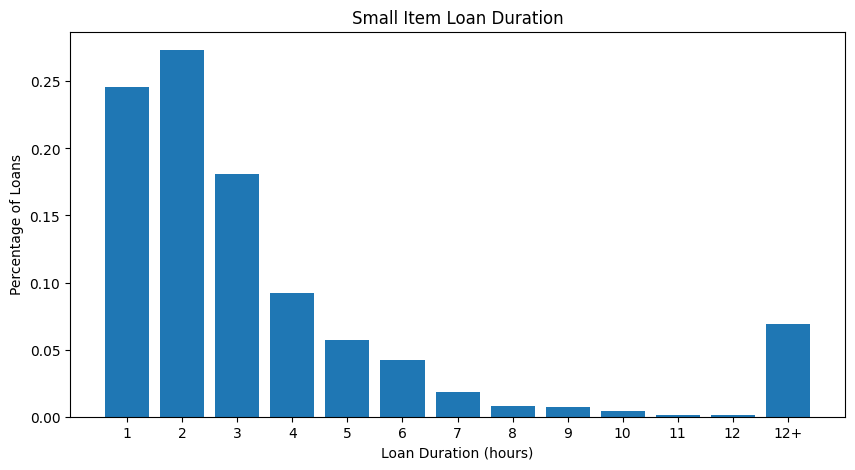

In [64]:
total_seconds = small_df_returned['Loan Duration'].dt.total_seconds().astype(int)
bins = [*range(0, 3600*13, 3600), total_seconds.max()]
bin_counts = pd.cut(total_seconds, list(bins)).value_counts(normalize=True, sort=False)
bins = [str(i) for i in range(1, 13)]
bins.append('12+')

# Plot the histogram
plt.figure(figsize=(10, 5))
plt.bar(bins, bin_counts)
plt.xlabel('Loan Duration (hours)')
plt.ylabel('Percentage of Loans')
plt.title('Small Item Loan Duration')
plt.show()

#### 3

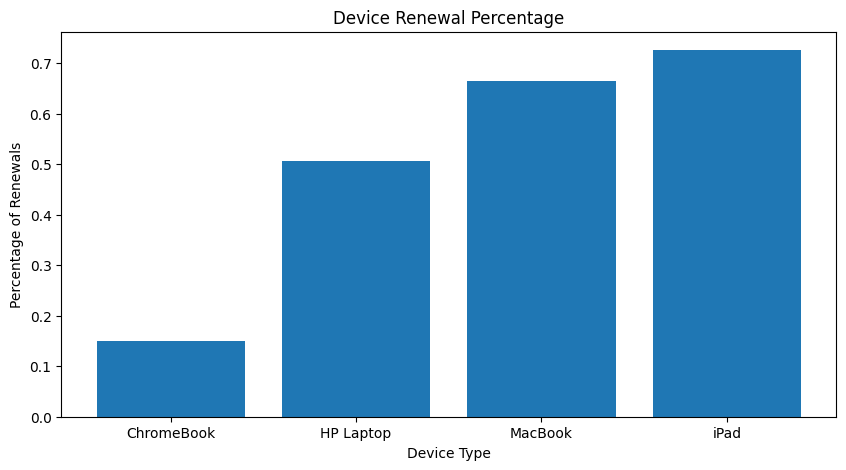

In [75]:
raw_counts = raw_df[raw_df['General Item Type'] == 'Device']['Item Type'].value_counts().sort_index().values
renewal_series = renewal_df[renewal_df['General Item Type'] == 'Device']['Item Type'].value_counts().sort_index()
renewal_counts = renewal_series.values
renewal_names = renewal_series.index
renewal_percent = renewal_counts / raw_counts

# Plot the histogram
plt.figure(figsize=(10, 5))
plt.bar(renewal_names, renewal_percent)
plt.xlabel('Device Type')
plt.ylabel('Percentage of Renewals')
plt.title('Device Renewal Percentage')
plt.show()